**Title:** Capstone 7 <br>
**Date:** 2023-01-24 <br>
**Author:** Jordaan Clarke

**Description**

Unsupervised learning using different clustering and feature analysis techniques on the `UsArrests.csv` dataset.

In [246]:
#Import the required libraries. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Resolve memory leak warning message.
os.environ["OMP_NUM_THREADS"] = "1"

**Data overview**

In [247]:
# Load the dataset.
data = pd.read_csv("UsArrests.csv")
display(data.head(3))
data.describe()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0


,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


There doesn't seem to be any missing values, and the the data is already in numeric formats. Nothing strange of note in the range of values, although they might benefit from scaling. 

In [249]:
display(data.City.unique())
print(f"Number of unique entries: {len(data.City.unique())}")

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

Number of unique entries: 50


As with the numeric columns, the cities seem to be in the correct format and it looks like all fifty entries are unique. No oddities such as whitespace or garbled text is observed. However, the column refers to cities, whereas the entries refer to states. We can quickly rename this before proceeding.

In [250]:
# Rename the city column.
data = data.rename(columns = {"City": "State"})
data.head(0)

,State,Murder,Assault,UrbanPop,Rape


**Examining the data: Distribution**

Looking at the distribution for each feature, we can see that they are generally asymmetrically multimodal, each containing around three peaks.

array([[<AxesSubplot:title={'center':'Murder'}>,
        <AxesSubplot:title={'center':'Assault'}>],
       [<AxesSubplot:title={'center':'UrbanPop'}>,
        <AxesSubplot:title={'center':'Rape'}>]], dtype=object)

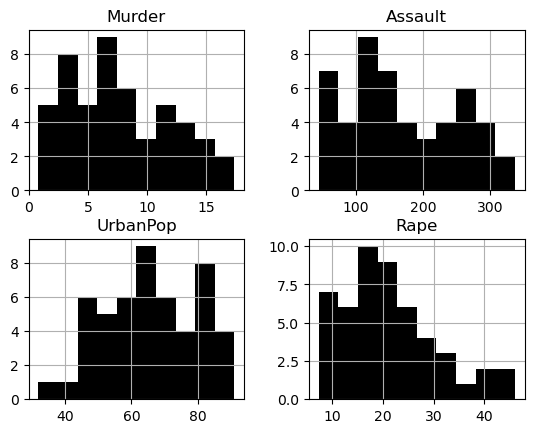

In [251]:
# Plot a histogram for each feature.
data.hist(color = "k")

**Examining the data: Correlation**

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Murder'),
  Text(0, 1.5, 'Assault'),
  Text(0, 2.5, 'UrbanPop'),
  Text(0, 3.5, 'Rape')])

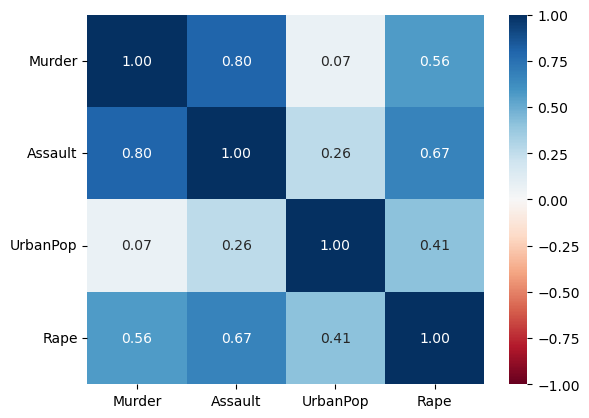

In [252]:
# Capture the correlation between variables.
data_c = data.iloc[:, 1:].corr()
display(data_c)

# Plot the correlation.
labels = data.columns[1:]
sns.heatmap(data_c, cmap = "RdBu", vmin = -1, vmax = 1, annot = True,
           fmt = ".2f", xticklabels = labels, yticklabels = labels)
plt.yticks(rotation = 0)

We can observe that correlation between features is always positive, and tends to be weaker when urban population is compared with other features. We would expect primary components that include urban population to be weaker. 

We can scale the data, then combine some of the features to see how the correlations change. While this won't tell us anything about which features will have greater importance in a model, it _can_ give us a better idea about the relationships between them.

In [253]:
# Standardise the data, and add the scaled values to the dataframe.
sc = StandardScaler()
data[["Mu_T", "As_T", "Ur_T", "Ra_T"]] = sc.fit_transform(data[["Murder", "Assault",
                                                               "UrbanPop", "Rape"]])

In [254]:
# Display original values
print(f"Original values:\n{data.iloc[:6, 1:5].values}\n")

#  Display scaled values.
data_s = data.iloc[:, 5:]
print(f"Scaled values:\n{data_s[:6]}\n")

# Fit a PCA model to the data with non-primary components removed.
pca = PCA(n_components = 3)
model = pca.fit_transform(data_s)
print(f"Modelled values:\n{model[:6]}")

Original values:
[[ 13.2 236.   58.   21.2]
 [ 10.  263.   48.   44.5]
 [  8.1 294.   80.   31. ]
 [  8.8 190.   50.   19.5]
 [  9.  276.   91.   40.6]
 [  7.9 204.   78.   38.7]]

Scaled values:
       Mu_T      As_T      Ur_T      Ra_T
0  1.255179  0.790787 -0.526195 -0.003451
1  0.513019  1.118060 -1.224067  2.509424
2  0.072361  1.493817  1.009122  1.053466
3  0.234708  0.233212 -1.084492 -0.186794
4  0.281093  1.275635  1.776781  2.088814
5  0.025976  0.402909  0.869548  1.883901

Modelled values:
[[ 0.98556588  1.13339238 -0.44426879]
 [ 1.95013775  1.07321326  2.04000333]
 [ 1.76316354 -0.74595678  0.05478082]
 [-0.14142029  1.11979678  0.11457369]
 [ 2.52398013 -1.54293399  0.5985568 ]
 [ 1.51456286 -0.98755509  1.09500699]]


,PC1,PC2,PC3
Murder,0.535899,0.418181,-0.341233
Assault,0.583184,0.187986,-0.268148
UrbanPop,0.278191,-0.872806,-0.378016
Rape,0.543432,-0.167319,0.817778


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Murder'),
  Text(0, 1.5, 'Assault'),
  Text(0, 2.5, 'UrbanPop'),
  Text(0, 3.5, 'Rape')])

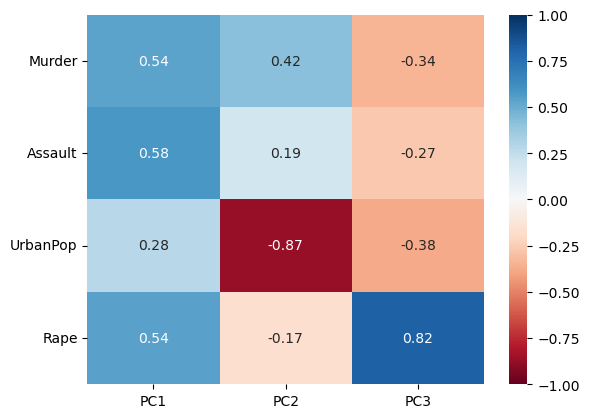

In [255]:
# Capture the correlation between variables.
pc_label = ["PC1", "PC2", "PC3"]
comp = pd.DataFrame(pca.components_, columns = data.columns[1:5], index = pc_label).T
display(comp)

# Plot the correlation.
sns.heatmap(comp, cmap = "RdBu", vmin = -1, vmax = 1, annot = True,
           fmt = ".2f", yticklabels = labels, xticklabels = pc_label)

plt.yticks(rotation = 0)

The analysis returns very mixed correlation across features, with medium correlation in both directions in PC1, mostly neutral for PC2 bar one strongly negative outlier, and even further mixed results in PC3.

**Examining the data: Kmeans clustering**

We can see a similar pattern to the heatmap of the unscaled data; generally positive correlation between features, with the exception of urban population, which has medium positive correlation for a single feature, and very little correlation in either direction for the other two. Since urban population has the least correlated data, we will look at features compared against this. 

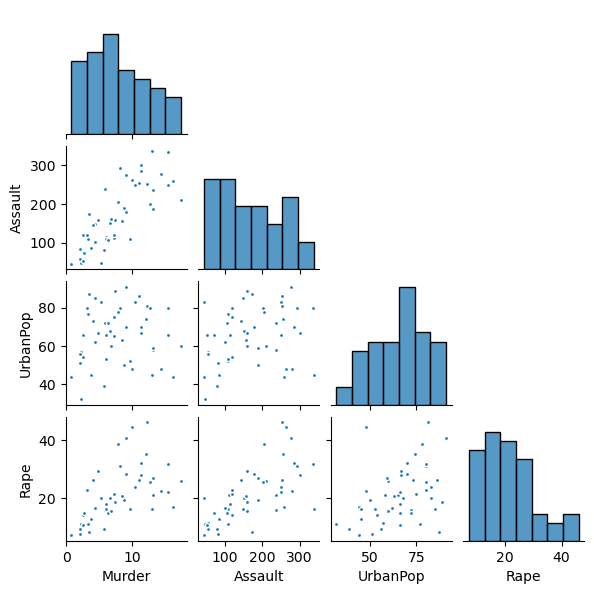

In [256]:
# Create a pair plot of the data.
sns.pairplot(data.iloc[:, 1:5], corner = True, height = 1.5, plot_kws = dict(marker = ".", linewidth = 1))
plt.show()

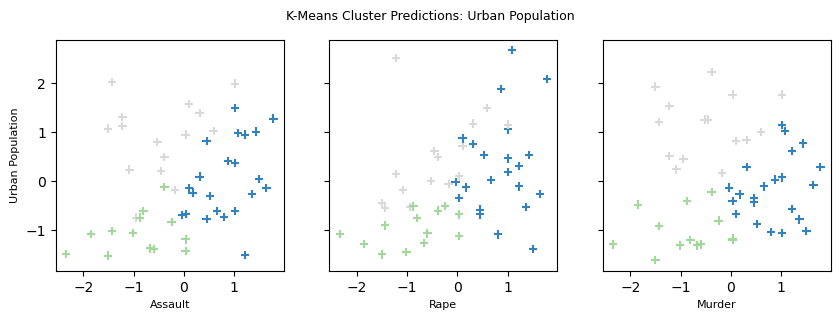

In [257]:
# Create a k-nearest neighbours model for the variable pairings.
km = KMeans(n_clusters = 3)

# Fit models for each comparison.
km1 = km.fit(data[["Ur_T", "As_T"]])
km2 = km.fit(data[["Ur_T", "Ra_T"]])
km3 = km.fit(data[["Ur_T", "Mu_T"]])

# Set labels for each model.
km1_c = km.labels_
km2_c = km.labels_
km3_c = km.labels_

# Create a 1x3 multiplot.
fig, ax = plt.subplots(1, 3, figsize = (10,3), sharey = True)

# Plot the data points for each variable pair.
ax[0].scatter(data_s["Ur_T"], data_s["As_T"], c = km1_c, cmap = "tab20c", marker = "+")
ax[1].scatter(data_s["Ur_T"], data_s["Ra_T"], c = km1_c, cmap = "tab20c", marker = "+")
ax[2].scatter(data_s["Ur_T"], data_s["Mu_T"], c = km1_c, cmap = "tab20c", marker = "+")

# # Customise axis labels and title.
ax[0].set_ylabel("Urban Population", fontsize = 8)
ax[0].set_xlabel("Assault", fontsize = 8)
ax[1].set_xlabel("Rape", fontsize = 8)
ax[2].set_xlabel("Murder", fontsize = 8)

fig.suptitle("K-Means Cluster Predictions: Urban Population", fontsize = 9)

plt.show()

The model seems to cluster for murder quite neatly, but for other offences there is some overlap in the clusters.  We can choose one of these to explore further and fit models with a variable number of clusters to examine how the clusters differ.

In [258]:
# Create variable k-nearest neighbour models for one of the variable pairings.
for k in range(1, 6):
    km = KMeans(n_clusters = k)
    
    # Fit models for each k-number and add to the dataframe.
    km_n = km.fit(data[["Ur_T", "Ra_T"]])
    data[f"km_n{k}"] = km.labels_

D:\Applications\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


A warning is generated for the environment variable when running this line. The variable is set in the first code block of this notebook, but the warning persists nonetheless, and it seems that this setting is dependent on the particular operating system from which this is run. It doesn't affect execution of the code, but it's something to be aware of. We can continue.

D:\Applications\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


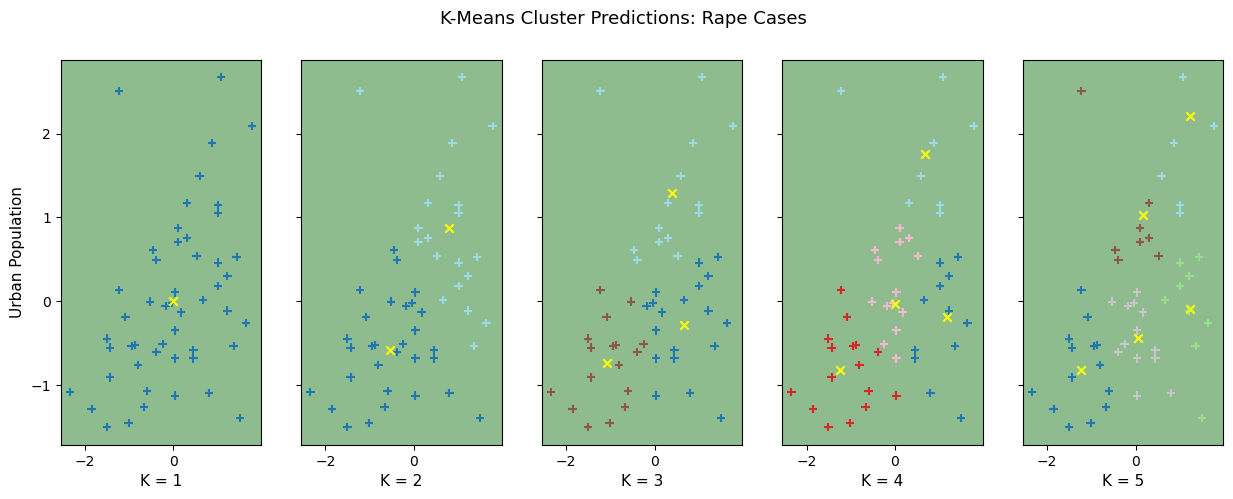

In [259]:
# Create a 1x5 multiplot.
fig, ax = plt.subplots(1, 5, figsize = (15,5), sharey = True, sharex = True)

# Customise axis labels and title.
ax[0].set_ylabel("Urban Population", fontsize = 11)
fig.suptitle("K-Means Cluster Predictions: Rape Cases", fontsize = 13)

# Filter the data.
data_k = data.loc[:, ["Ur_T", "Ra_T"]]

# Declare an empty list to capture accuracy scores.
score = []

# Plot the clusters, their predictions and calculate accuracy using a for loop.
for y, ax in enumerate(fig.axes, start = 1):

    # Plot the data points.
    ax.scatter(data["Ur_T"], data["Ra_T"], c = data[f"km_n{y}"], cmap = "tab20", marker = "+")
    ax.set_xlabel(f"K = {y}", fontsize = 11)
    ax.set_facecolor("darkseagreen")
    
    # Calculate and plot the cluster centres.
    km = KMeans(n_clusters = y)
    kmf = km.fit(data_k)
    cc = km.cluster_centers_
    ax.scatter(cc[:, 0], cc[:, 1], color = "yellow", marker = "x")
    
    # Capture predictions and accuracy.
    kmp = km.predict(data_k)
    if y > 1: 
        kms = silhouette_score(data_k, labels = kmp)
        score.append(kms)
    
plt.show()

In [260]:
# Display the accuracy scores.
for x, y in enumerate(score, start = 2): print(f"Accuracy of model with {x} clusters: {y}")

Accuracy of model with 2 clusters: 0.40696592673346693
Accuracy of model with 3 clusters: 0.3653508598851884
Accuracy of model with 4 clusters: 0.3580569501681544
Accuracy of model with 5 clusters: 0.3573784703797101


We can see that the model predictions are a bit funky. The clusters centres are generally well placed up until three clusters in, wherein they start to become disjointed. If we look at the accuracy of the predictions we see the same thing, with accuracy generally getting worse, the more clusters there are; three clusters seems to be the optimum, providing enough cluster variation and representation among data points.

**Examining the data: Hierarchical clustering**

Using the same data, we can also look at how it responds to hierarchical clustering. One way to do this is with dendrograms, and if we differ the methods used to calculate the distance between clusters, we can explore how the groups of clusters change.

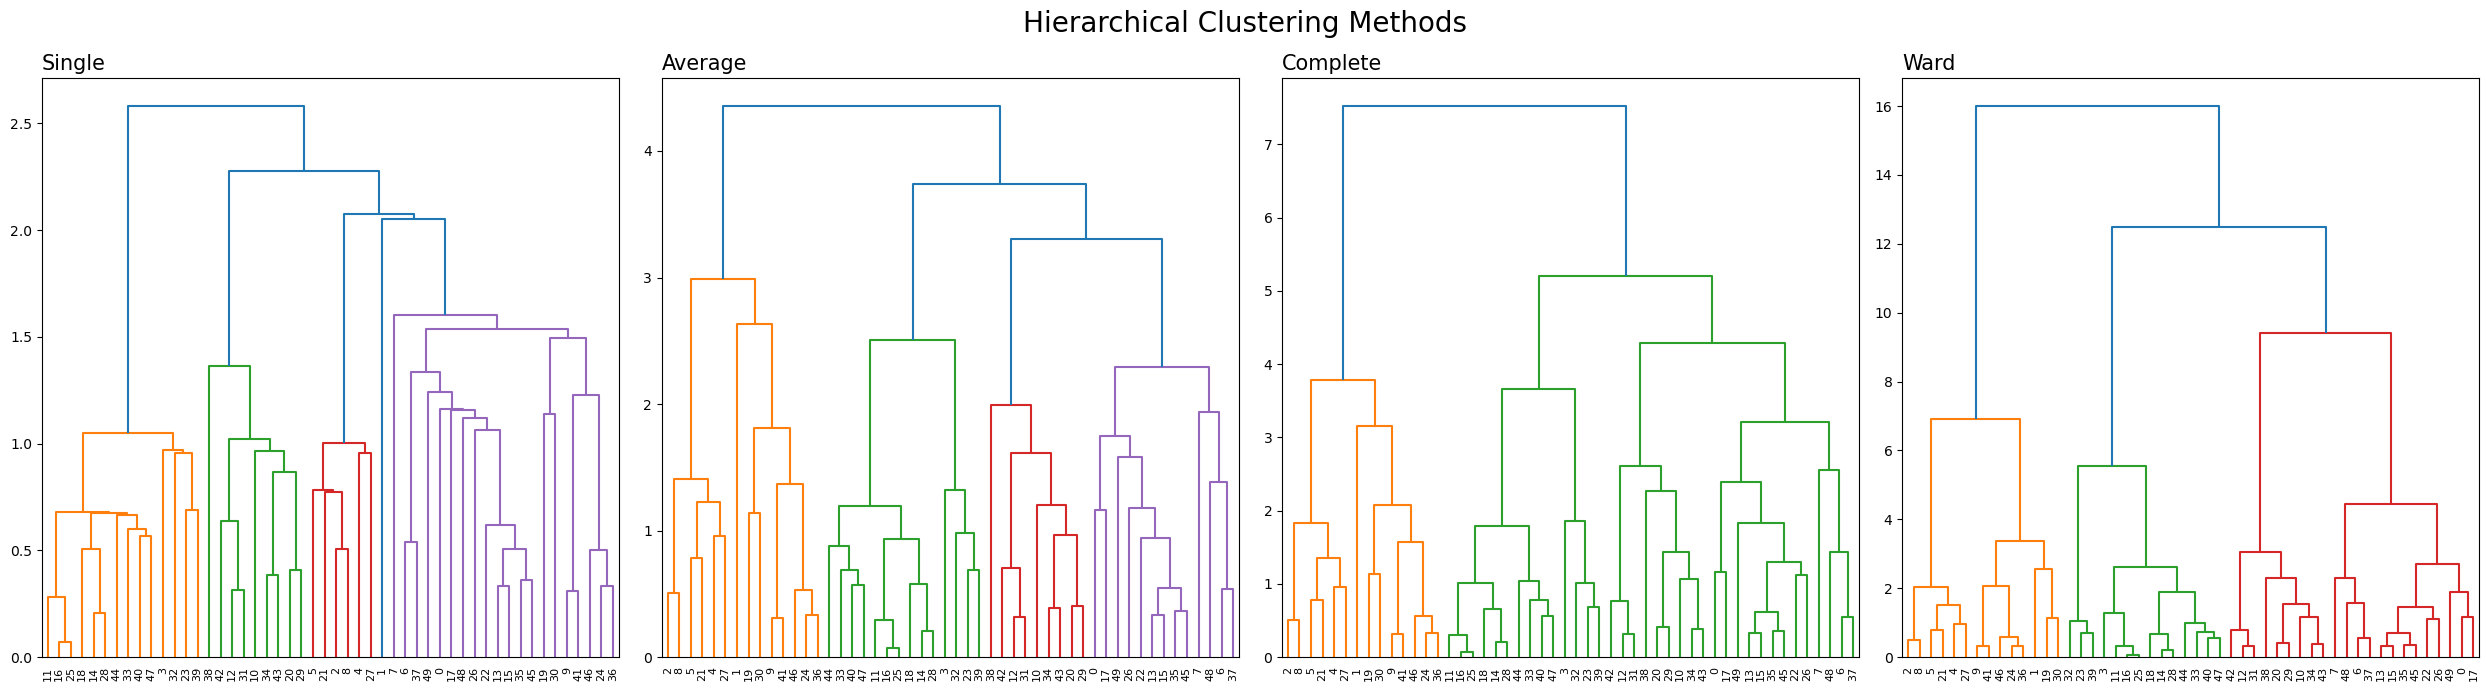

In [261]:
# Isolate the data for clustering.
x = data.iloc[:, 6:]

# Create a 1x4 multiplot.
fig, den = plt.subplots(1, 4, figsize = (25,7))

# Plot the dendrograms.
d1 = dendrogram(linkage(x, method = "single"), ax = den[0], orientation = "top")
d2 = dendrogram(linkage(x, method = "average"), ax = den[1])
d3 = dendrogram(linkage(x, method = "complete"), ax = den[2])
d3 = dendrogram(linkage(x, method = "ward"), ax = den[3])

# Set titles for each subplot.
den[0].set_title("Single", fontsize = 15, loc = "left")
den[1].set_title("Average", fontsize = 15, loc = "left")
den[2].set_title("Complete", fontsize = 15, loc = "left")
den[3].set_title("Ward", fontsize = 15, loc = "left")

fig.suptitle("Hierarchical Clustering Methods", fontsize = 20)

fig.tight_layout()

We can have a look at one of these a bit closer and see how it performs at different depths.

Let's proceed with the `Average` method as it offers the best combination of clade size, while still offering broad cluster variation. If we fit a model and run it through a loop, changing the number of clusters iteratively, we can examine which number of clusters provides the best predictions. If we wanted to, we could also change the affinity to modify how distances between observations are calculated, as this would provide different results, but we're going to leave this using the euclidean calculation.

In [262]:
# Iterate over the modelling process, changing the number of clusters each time.
for y in range(2, 9):
    
    # Model the data with agglomerative clustering using the chosen configuration for one of the above dendrograms.
    ac = AgglomerativeClustering(n_clusters = y, affinity = "euclidean", linkage = "average")

    # Predict the cluster assignments, and score the model.
    pred = ac.fit_predict(x)
    ac_score = silhouette_score(x, labels = pred.reshape(-1,))
    print(f"Clusters: {y} | Silhouette Score: {round(ac_score, 6)}")

Clusters: 2 | Silhouette Score: 0.337851
Clusters: 3 | Silhouette Score: 0.398524
Clusters: 4 | Silhouette Score: 0.459968
Clusters: 5 | Silhouette Score: 0.481586
Clusters: 6 | Silhouette Score: 0.471694
Clusters: 7 | Silhouette Score: 0.486995
Clusters: 8 | Silhouette Score: 0.478501


The number of clusters providing the best accuracy seems to be five. The accuracy increases with the number of clusters provided to the model, but as dendrograms can be computationally expensive, it makes sense to keep this at a reasonably small value; one that straddles both performance and accuracy. While it doesn't make much of a difference in this dataset, for a larger one, it would be an important factor to consider.

**Observations**

When compared to the result of the k-means clustering analysis which returned three clusters as optimal, we can see that there may be some merit to using smaller clusters. While k-means assigns clusters at random and slowly refines them based on data point distances, hierarchical clustering treats each data point as its own cluster and looks for similarities. Which method would be best depends entirely on the dataset and the objectives of the analysis. 

We've also looked at principal components in the data, which returned quite varied results that were difficult to interpret. One of the key issues with using this type of analysis on a dataset like this, is that there are too few features to make the dimension reduction a useful exercise.